<a href="https://colab.research.google.com/github/ds-zavadskiy/sandbox/blob/main/%D0%92%D0%9A%D0%A0_%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7_%D1%81%D1%82%D0%BE%D0%B8%D0%BC%D0%BE%D1%81%D1%82%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Импорт библиотек
from math import sqrt
from matplotlib import pyplot as plt
from numpy import mean
from pandas import DataFrame, concat
from pandas import Grouper
from pandas.plotting import autocorrelation_plot
from scipy import stats
from scipy.stats import boxcox, chi2, linregress
from scipy.stats import t as student
from sklearn import tree
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, explained_variance_score
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.svm import SVC, SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import numpy as np
import os
import pandas as pd
import scipy.stats
import seaborn as sns
import statsmodels.api as sm
import time
import warnings
import xgboost as xgb

In [2]:
os.chdir('/content/drive/MyDrive/data/Work')

In [3]:
#Создание датафрейма
data = pd.read_excel('Contract_TC.xlsx')
df = pd.DataFrame(data)
df

,power,diameter,length,pressure,app_type,district,day,month,year,term,GDRP,gas_price,summ
0,10,63,100,0.300,1,Всеволожский район,1,10,2018,18,1147,62,324
1,5,110,67,0.300,1,Лодейнопольский район,1,11,2018,27,1147,31,176
2,5,63,42,0.005,1,Лодейнопольский район,2,4,2018,17,1147,31,177
3,5,63,12,0.300,1,Гатчинский район,2,7,2018,18,1147,31,180
4,5,63,36,0.005,1,Гатчинский район,3,4,2018,38,1147,31,240
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010,4,63,81,0.300,1,Ломоносовский район,28,7,2023,24,1731,30,330
1011,7,63,50,0.300,2,Тосненский район,28,7,2023,18,1731,53,233
1012,7,32,7,0.600,1,Ломоносовский район,29,9,2023,8,1731,53,108
1013,7,32,6,0.600,1,Ломоносовский район,29,9,2023,8,1731,53,105


In [4]:
#Описание параметров датафрейма
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1015 entries, 0 to 1014
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   power      1015 non-null   int64  
 1   diameter   1015 non-null   int64  
 2   length     1015 non-null   int64  
 3   pressure   1015 non-null   float64
 4   app_type   1015 non-null   int64  
 5   district   1015 non-null   object 
 6   day        1015 non-null   int64  
 7   month      1015 non-null   int64  
 8   year       1015 non-null   int64  
 9   term       1015 non-null   int64  
 10  GDRP       1015 non-null   int64  
 11  gas_price  1015 non-null   int64  
 12  summ       1015 non-null   int64  
dtypes: float64(1), int64(11), object(1)
memory usage: 103.2+ KB


## **Показатели**

In [5]:
#Распределение по типам заявителей
df['app_type'].value_counts()

1    735
2    243
3     37
Name: app_type, dtype: int64

In [6]:
#Средняя стоимость подключения
df['summ'].mean().round(2)

180.9

In [7]:
#Доля договоров дешевле или равных средней стоимости
(df[(df.summ <= df['summ'].mean())].value_counts().sum()) / (df['summ'].value_counts().sum())

0.6610837438423646

In [8]:
#Распределение по годам
df['year'].value_counts(sort = False)

2018    143
2019    159
2020    221
2021    208
2022    171
2023    113
Name: year, dtype: int64

In [9]:
#Распределение по годам (в долях)
df['year'].sort_values().value_counts(sort = False, normalize = True).round(2)

2018    0.14
2019    0.16
2020    0.22
2021    0.20
2022    0.17
2023    0.11
Name: year, dtype: float64

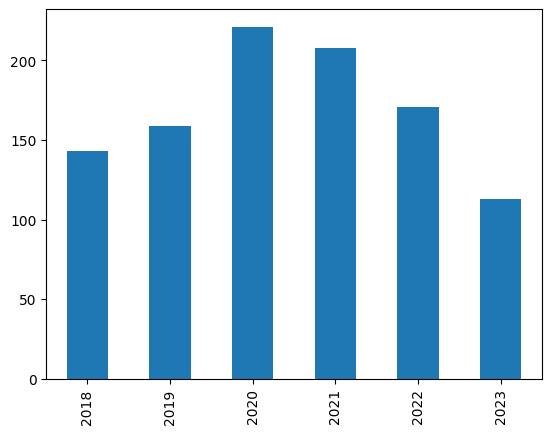

In [10]:
df['year'].value_counts(sort = False).plot(kind='bar')
plt.show()

In [11]:
#Распределение по месяцам
df['month'].sort_values().value_counts(sort = False)

1      57
2      87
3      80
4      82
5      67
6      93
7     117
8      97
9      83
10     92
11     78
12     82
Name: month, dtype: int64

In [12]:
#Средний объем потребления газа
df['power'].mean().round(2)

34.97

In [13]:
#Доля договоров в которых объем потребления меньше или равен среднему
(df[(df.power <= df['power'].mean())].value_counts().sum()) / (df['power'].value_counts().sum())

0.7940886699507389

In [14]:
#Распределение по объему потреблению газа
df['power'].value_counts().head(10)

5     370
7      76
10     36
11     32
4      31
21     24
8      24
12     19
6      18
9      17
Name: power, dtype: int64

In [15]:
#Распределение по долям объема потреблению газа физ лицами
df[df['app_type'] == 1]['power'].sort_values().value_counts(sort = False, normalize = True).head(15)

4     0.042177
5     0.474830
6     0.023129
7     0.084354
8     0.027211
9     0.020408
10    0.039456
11    0.025850
12    0.024490
13    0.016327
14    0.010884
15    0.016327
16    0.005442
17    0.009524
18    0.006803
Name: power, dtype: float64

In [16]:
#Средняя протяженность газопровода
df['length'].mean().round(2)

40.64

In [17]:
#Распределение по протяженности
df['length'].value_counts().head(10)

10    69
5     48
20    40
15    40
12    37
11    32
14    32
8     30
30    26
16    26
Name: length, dtype: int64

In [18]:
#Распределение по диаметрам газопровода в точке подключения
df['diameter'].value_counts().head(10)

63     759
32     145
90      62
110     30
160      6
57       3
225      2
159      2
89       2
40       2
Name: diameter, dtype: int64

In [19]:
#Распределение по давлению, в %
df['pressure'].value_counts(normalize=True).round(3)

0.300    0.482
0.600    0.285
0.005    0.231
1.200    0.003
Name: pressure, dtype: float64

In [20]:
#Распределение по давлению
df['pressure'].value_counts().round(3)

0.300    489
0.600    289
0.005    234
1.200      3
Name: pressure, dtype: int64

In [21]:
#Распределение по давлению по категориям заявителей
df.groupby('pressure')['app_type'].value_counts()

pressure  app_type
0.005     1           189
          2            34
          3            11
0.300     1           348
          2           125
          3            16
0.600     1           196
          2            83
          3            10
1.200     1             2
          2             1
Name: app_type, dtype: int64

In [22]:
#Средний срок подключения
df['term'].mean().round(2)

22.97

In [23]:
#Распределение по сроку подключения
df.term.value_counts().head(5)

24    535
18    116
36     84
4      66
8      33
Name: term, dtype: int64

In [24]:
#Количество и доля договоров по сроком исполнения
df[(df.term <= 12)].value_counts().sum()

124

In [25]:
(df[(df.term <= 12)].value_counts().sum() / df['term'].value_counts().sum()).round(3)

0.122

In [26]:
df[(df.term > 12) & (df.term <= 24)]['term'].value_counts().sum()

706

In [27]:
(df[(df.term > 12) & (df.term <= 24)]['term'].value_counts().sum()/ df['term'].value_counts().sum()).round(3)

0.696

In [28]:
df[(df.term > 24) & (df.term <= 36)]['term'].value_counts().sum()

140

In [29]:
(df[(df.term > 24) & (df.term <= 36)]['term'].value_counts().sum()/ df['term'].value_counts().sum()).round(3)

0.138

In [30]:
df[(df.term > 36) & (df.term <= 48)]['term'].value_counts().sum()

45

In [31]:
(df[(df.term > 36) & (df.term <= 48)]['term'].value_counts().sum()/ df['term'].value_counts().sum()).round(3)

0.044

In [32]:
#Распределение по районам заявителя
df['district'].value_counts()

Всеволожский район       208
Гатчинский район         179
Ломоносовский район      121
Выборгский район         109
Тосненский район          92
Приозерский район         63
Кировский район           54
Кингисеппский район       51
Лужский район             29
Лодейнопольский район     26
Волховский район          25
Волосовский район         17
Сосновоборский ГО         14
Тихвинский район          10
Киришский район            6
Сланцевский район          5
Бокситогорский район       5
Подпорожский район         1
Name: district, dtype: int64

## **Преобразование районов в коды**

In [33]:
#Преобразование районов в коды
region = {
    'Бокситогорский район' : 1,
    'Волосовский район' : 2,
    'Волховский район' : 3,
    'Всеволожский район' : 4,
    'Выборгский район' : 5,
    'Гатчинский район' : 6,
    'Кингисеппский район' : 7,
    'Киришский район' : 8,
    'Кировский район' : 9,
    'Лодейнопольский район' : 10,
    'Ломоносовский район' : 11,
    'Лужский район' : 12,
    'Подпорожский район' : 13,
    'Приозерский район' : 14,
    'Сланцевский район' : 15,
    'Тихвинский район' : 16,
    'Тосненский район' : 17,
    'Сосновоборский ГО' : 18,
}

In [34]:
df['district_id'] = df['district'].map(region)

In [35]:
df = df.drop('district', axis=1)

In [36]:
df = df[['power', 'diameter', 'length', 'pressure', 'app_type', 'district_id', 'day', 'month', 'year', 'term', 'GDRP', 'gas_price', 'summ']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1015 entries, 0 to 1014
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   power        1015 non-null   int64  
 1   diameter     1015 non-null   int64  
 2   length       1015 non-null   int64  
 3   pressure     1015 non-null   float64
 4   app_type     1015 non-null   int64  
 5   district_id  1015 non-null   int64  
 6   day          1015 non-null   int64  
 7   month        1015 non-null   int64  
 8   year         1015 non-null   int64  
 9   term         1015 non-null   int64  
 10  GDRP         1015 non-null   int64  
 11  gas_price    1015 non-null   int64  
 12  summ         1015 non-null   int64  
dtypes: float64(1), int64(12)
memory usage: 103.2 KB


## **Статистика**

In [37]:
#Статистика
df.describe().round(2)

,power,diameter,length,pressure,app_type,district_id,day,month,year,term,GDRP,gas_price,summ
count,1015.00,1015.00,1015.00,1015.00,1015.00,1015.00,1015.00,1015.0,1015.00,1015.00,1015.00,1015.00,1015.00
mean,34.97,62.92,40.64,0.32,1.31,8.22,16.42,6.7,2020.44,22.97,1386.81,238.86,180.90
std,70.63,20.93,40.61,0.22,0.54,4.47,8.29,3.3,1.55,8.81,197.81,486.80,105.41
min,4.00,32.00,5.00,0.00,1.00,1.00,1.00,1.0,2018.00,4.00,1147.00,25.00,55.00
25%,5.00,63.00,12.00,0.30,1.00,4.00,9.00,4.0,2019.00,18.00,1223.00,33.00,101.00
50%,8.00,63.00,22.00,0.30,1.00,6.00,17.00,7.0,2020.00,24.00,1238.00,55.00,142.00
75%,25.00,63.00,58.50,0.60,2.00,11.00,23.00,9.0,2022.00,24.00,1590.00,171.00,229.00
max,500.00,315.00,277.00,1.20,3.00,18.00,31.00,12.0,2023.00,48.00,1731.00,3451.00,499.00


In [38]:
#Корреляция Спирмен
df.corr('spearman').round(2)

,power,diameter,length,pressure,app_type,district_id,day,month,year,term,GDRP,gas_price,summ
power,1.00,0.22,0.09,0.15,0.54,-0.03,0.04,-0.07,0.30,-0.03,0.30,0.98,0.15
diameter,0.22,1.00,0.21,-0.09,0.20,-0.06,0.01,-0.04,-0.21,0.16,-0.21,0.19,0.19
length,0.09,0.21,1.00,0.01,0.14,-0.08,-0.05,-0.06,-0.12,0.13,-0.12,0.07,0.87
pressure,0.15,-0.09,0.01,1.00,0.09,-0.04,-0.01,-0.00,0.21,0.14,0.21,0.20,0.03
app_type,0.54,0.20,0.14,0.09,1.00,-0.02,0.04,-0.04,0.18,0.06,0.18,0.53,0.18
district_id,-0.03,-0.06,-0.08,-0.04,-0.02,1.00,-0.00,0.02,-0.02,0.03,-0.02,-0.03,-0.10
day,0.04,0.01,-0.05,-0.01,0.04,-0.00,1.00,0.01,-0.04,-0.03,-0.04,0.04,-0.04
month,-0.07,-0.04,-0.06,-0.00,-0.04,0.02,0.01,1.00,-0.17,0.01,-0.17,-0.08,-0.06
year,0.30,-0.21,-0.12,0.21,0.18,-0.02,-0.04,-0.17,1.00,-0.34,1.00,0.43,0.02
term,-0.03,0.16,0.13,0.14,0.06,0.03,-0.03,0.01,-0.34,1.00,-0.34,-0.06,0.10


In [39]:
#Корреляция Кендалл
df.corr('kendall').round(2)

,power,diameter,length,pressure,app_type,district_id,day,month,year,term,GDRP,gas_price,summ
power,1.00,0.19,0.06,0.13,0.45,-0.02,0.03,-0.05,0.23,-0.03,0.23,0.93,0.11
diameter,0.19,1.00,0.17,-0.08,0.19,-0.05,0.01,-0.03,-0.18,0.14,-0.18,0.15,0.15
length,0.06,0.17,1.00,0.00,0.12,-0.06,-0.04,-0.04,-0.08,0.10,-0.08,0.05,0.70
pressure,0.13,-0.08,0.00,1.00,0.09,-0.03,-0.01,-0.00,0.18,0.12,0.18,0.16,0.02
app_type,0.45,0.19,0.12,0.09,1.00,-0.01,0.03,-0.03,0.15,0.05,0.15,0.43,0.15
district_id,-0.02,-0.05,-0.06,-0.03,-0.01,1.00,-0.00,0.01,-0.02,0.02,-0.02,-0.02,-0.07
day,0.03,0.01,-0.04,-0.01,0.03,-0.00,1.00,0.01,-0.03,-0.02,-0.03,0.03,-0.03
month,-0.05,-0.03,-0.04,-0.00,-0.03,0.01,0.01,1.00,-0.12,0.01,-0.12,-0.06,-0.04
year,0.23,-0.18,-0.08,0.18,0.15,-0.02,-0.03,-0.12,1.00,-0.28,1.00,0.35,0.02
term,-0.03,0.14,0.10,0.12,0.05,0.02,-0.02,0.01,-0.28,1.00,-0.28,-0.05,0.07


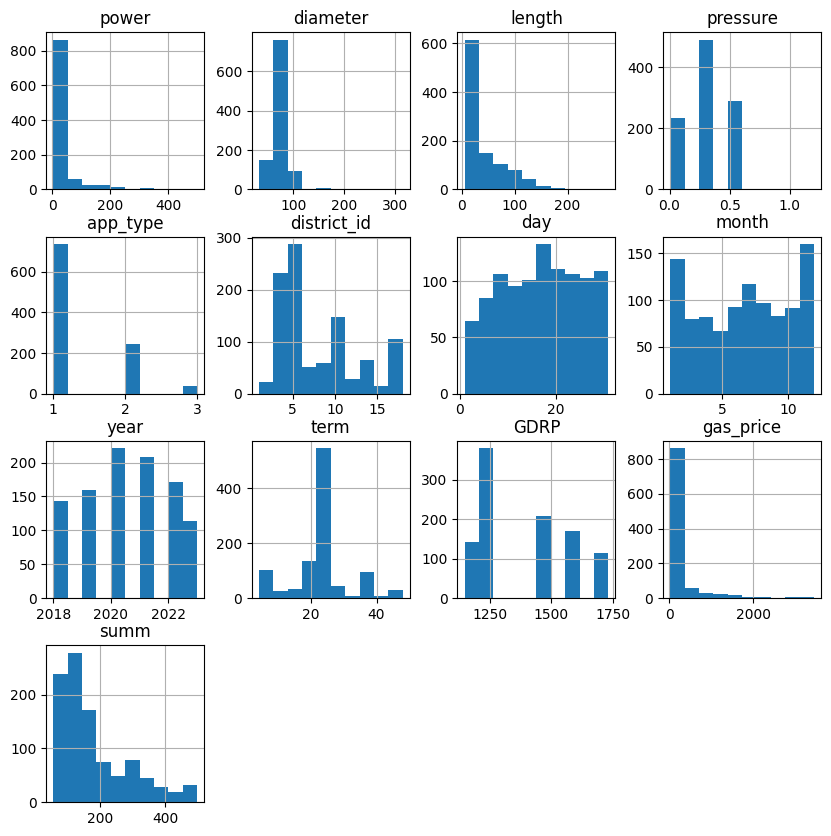

In [40]:
#Гистограммы распределения
df.hist(figsize=(10,10))
plt.show()

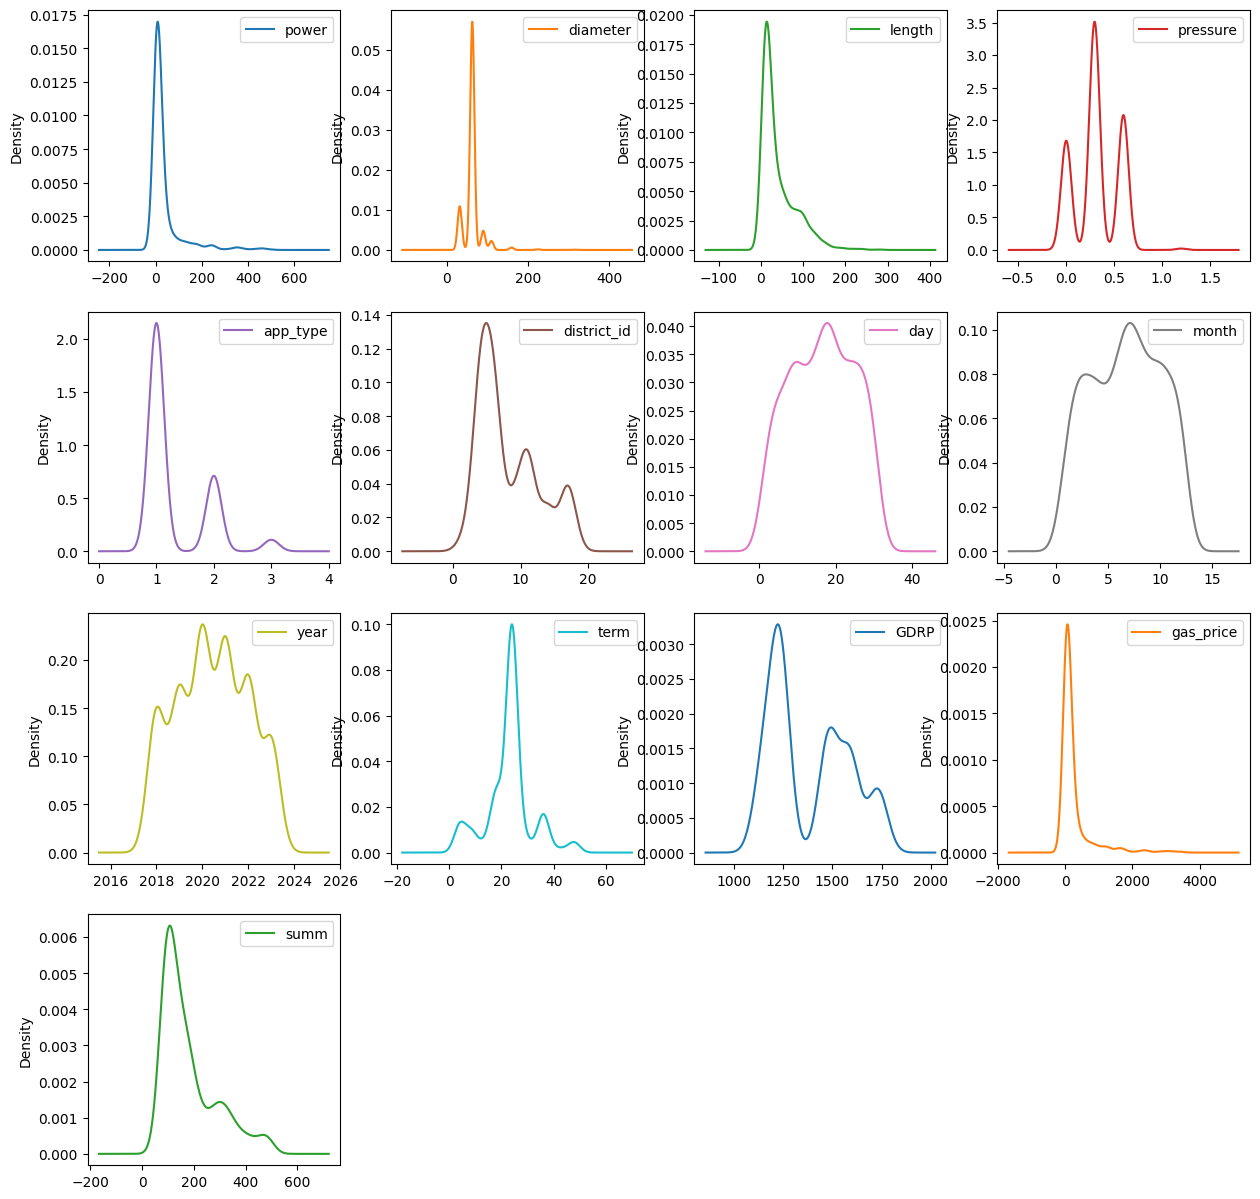

In [41]:
#Граифики распределения
df.plot(kind='kde', subplots=True, layout=(4,4), sharex=False, sharey=False, figsize=(15,15))
plt.show()

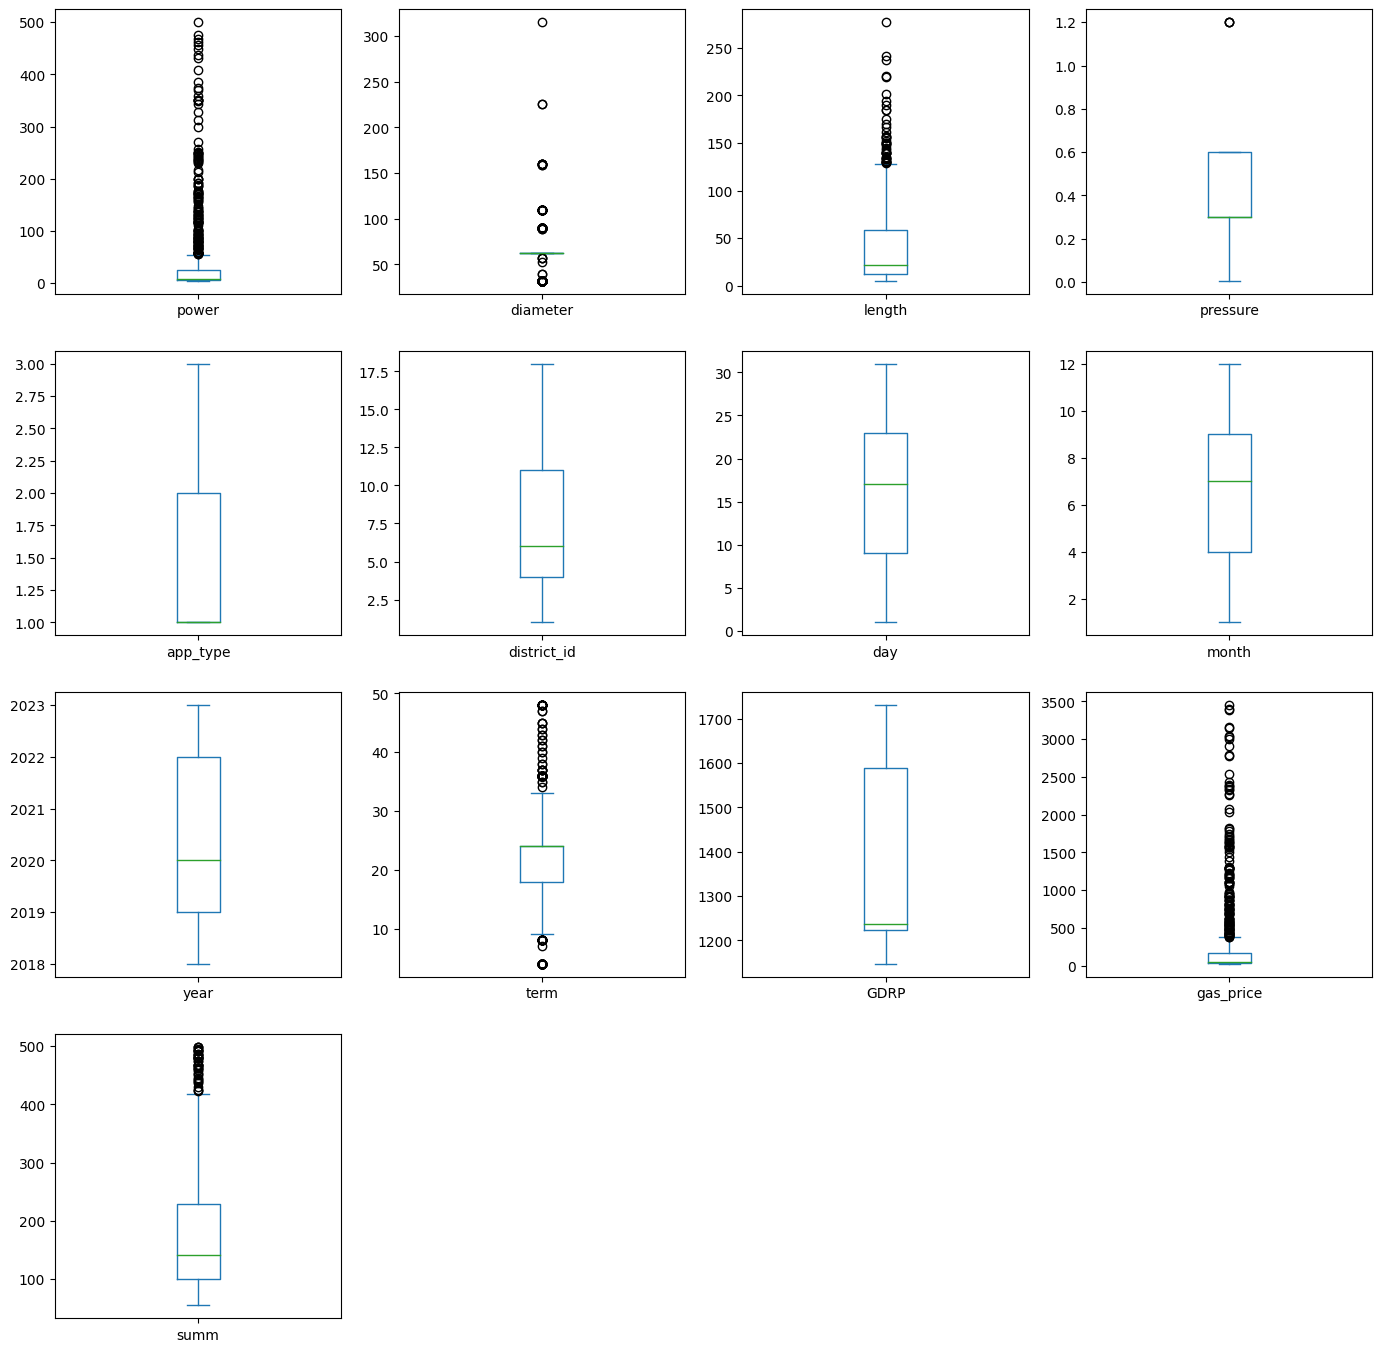

In [42]:
#"Ящики с усами"
df.plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False, figsize=(17,17))
plt.show()

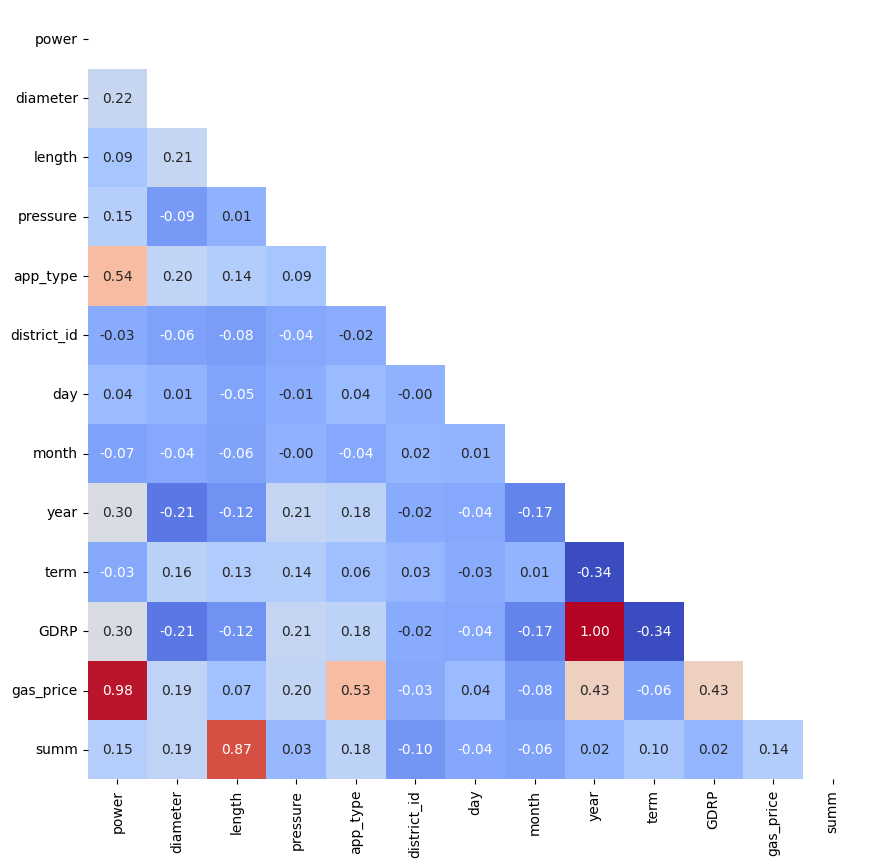

In [43]:
#Корреляционная матрица по Спиремну
fig = plt.figure(figsize=(10,10))
matrix = np.triu(df.corr())
sns.heatmap(df.corr('spearman'), annot = True, fmt = '.2f', cmap= 'coolwarm', cbar=False, mask=matrix)
plt.show()

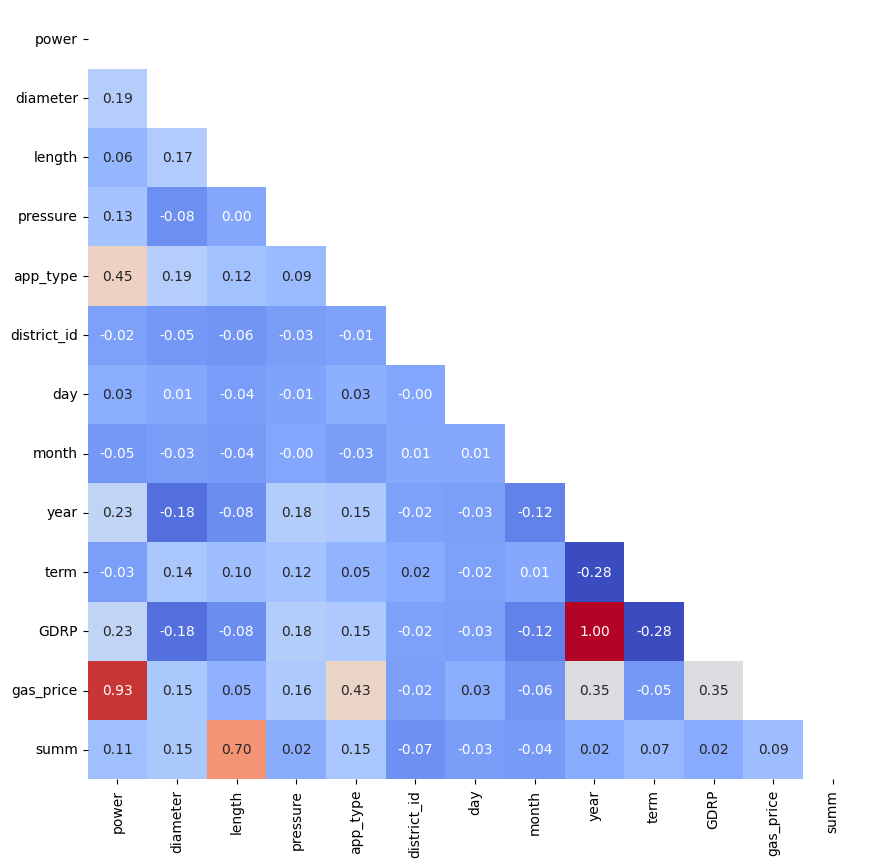

In [44]:
#Корреляционная матрица по Кендаллу
fig = plt.figure(figsize=(10,10))
matrix = np.triu(df.corr())
sns.heatmap(df.corr('kendall'), annot = True, fmt = '.2f', cmap= 'coolwarm', cbar=False, mask=matrix)
plt.show()

## **Проверка на нормальность распределения**



In [45]:
#Проверка на нормальность распределения
stat, p = stats.shapiro(df['summ'])
print('Statistics=%.3f, p-value=%.3f' % (stat, p))

Statistics=0.847, p-value=0.000


In [46]:
stat, p = scipy.stats.normaltest(df['summ'])
print('Statistics=%.3f, p-value=%.3f' % (stat, p))

Statistics=181.739, p-value=0.000


In [47]:
stat, p = stats.shapiro(np.log1p(df['summ']))
print('Statistics=%.3f, p-value=%.3f' % (stat, p))

Statistics=0.949, p-value=0.000


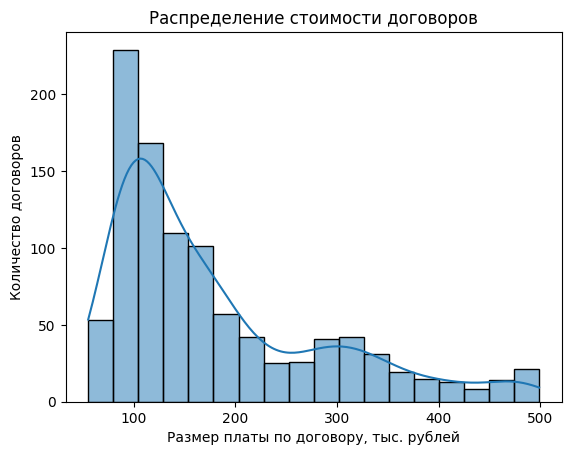

In [48]:
#Гистограмма распределения
np.random.seed(0)
sns.histplot(df['summ'], kde=True)
plt.title('Распределение стоимости договоров')
plt.xlabel("Размер платы по договору, тыс. рублей")
plt.ylabel("Количество договоров")
plt.show()

In [49]:
#Преобразование Бокса-Кокса
df['Transformed_Data'], _ = stats.boxcox(df['summ'])

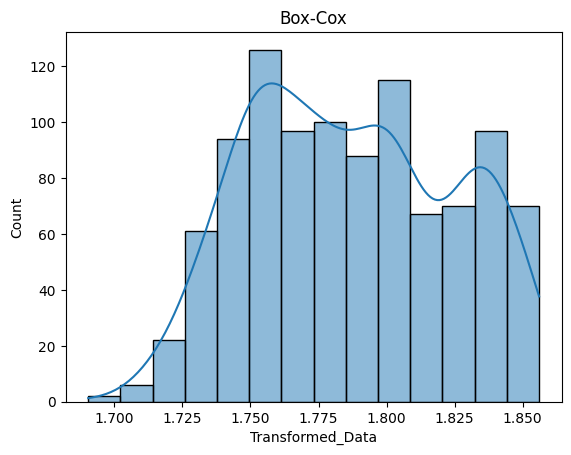

In [50]:
sns.histplot(df['Transformed_Data'], kde=True)
plt.title('Box-Cox')
plt.show()

In [51]:
stat, p = stats.shapiro(df['Transformed_Data'])
print('Statistics=%.3f, p-value=%.3f' % (stat, p))

Statistics=0.970, p-value=0.000


In [52]:
df = df.drop('Transformed_Data', axis=1)

## **Введение новой переменной**

In [53]:
#Введение новой переменной
pipe = {
    2018 : 1758,
    2019 : 1953,
    2020 : 1958,
    2021 : 2127,
    2022 : 2675,
    2023 : 2423
}
pipe

{2018: 1758, 2019: 1953, 2020: 1958, 2021: 2127, 2022: 2675, 2023: 2423}

In [54]:
df[df['year'] == 2018]['power'].mean()

7.741258741258742

In [55]:
project = {
    2018 : int(df.loc[df['year'] == 2018, 'power'].mean() * 5845),
    2019 : 26409,
    2020 : 31730,
    2021 : 32965,
    2022 : 43692,
    2023 : 42140
}
project

{2018: 45247, 2019: 26409, 2020: 31730, 2021: 32965, 2022: 43692, 2023: 42140}

In [56]:
install = {
    2018 : 36275,
    2019 : 27718,
    2020 : 16551,
    2021 : 29232,
    2022 : 29505,
    2023 : 29471
}
install

{2018: 36275, 2019: 27718, 2020: 16551, 2021: 29232, 2022: 29505, 2023: 29471}

In [57]:
df['calc_price'] = ((df['year'].map(pipe) * df['length'] + df['year'].map(project) + df['year'].map(install))/1000).astype(int)

In [58]:
df = df[['power', 'diameter', 'length', 'pressure', 'app_type', 'district_id', 'day', 'month', 'year', 'term', 'GDRP', 'gas_price', 'calc_price', 'summ']]
df.head(10)

,power,diameter,length,pressure,app_type,district_id,day,month,year,term,GDRP,gas_price,calc_price,summ
0,10,63,100,0.300,1,4,1,10,2018,18,1147,62,257,324
1,5,110,67,0.300,1,10,1,11,2018,27,1147,31,199,176
2,5,63,42,0.005,1,10,2,4,2018,17,1147,31,155,177
3,5,63,12,0.300,1,6,2,7,2018,18,1147,31,102,180
4,5,63,36,0.005,1,6,3,4,2018,38,1147,31,144,240
5,5,63,31,0.300,1,5,3,7,2018,36,1147,31,136,175
6,15,32,23,0.300,1,5,3,7,2018,27,1147,94,121,105
7,5,63,44,0.300,1,6,3,9,2018,48,1147,31,158,185
8,5,63,65,0.300,1,6,3,12,2018,26,1147,31,195,224
9,5,63,80,0.005,1,11,4,4,2018,27,1147,31,222,175


In [59]:
print(df['summ'].corr(df['calc_price'], 'spearman'))

0.8925973233329109


In [60]:
print(df['summ'].corr(df['calc_price'], 'kendall'))

0.7307136065821769


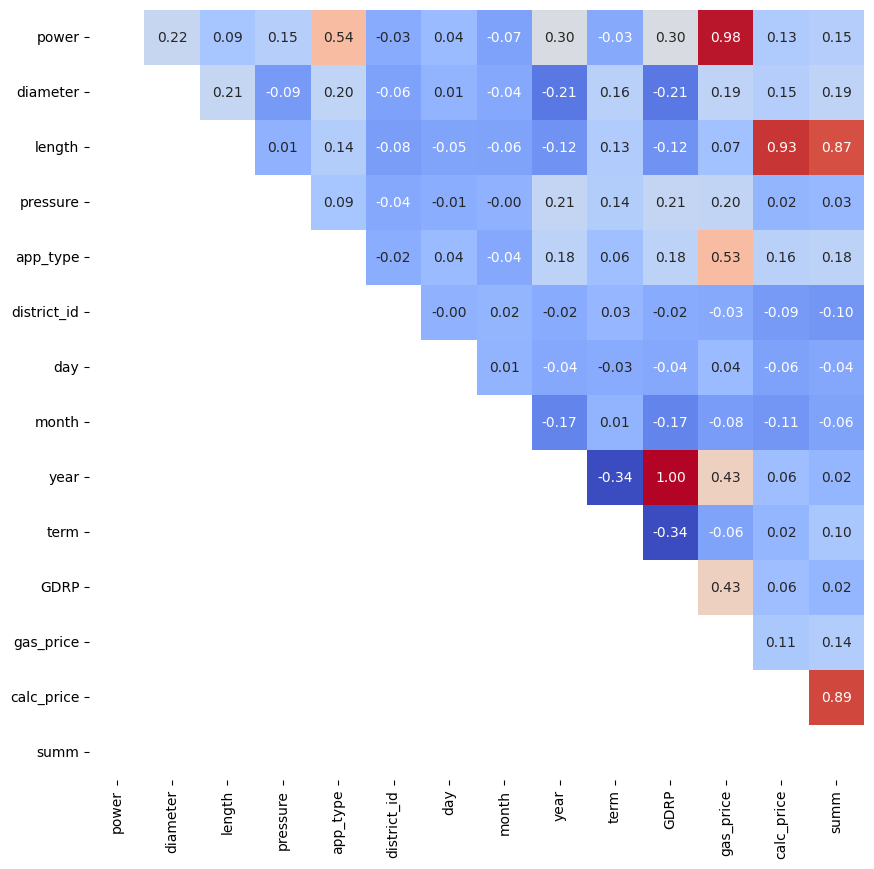

In [61]:
fig = plt.figure(figsize=(10,10))
matrix = np.tril(df.corr())
sns.heatmap(df.corr('spearman'), annot = True, fmt = '.2f', cmap= 'coolwarm', cbar=False, mask=matrix)
plt.show()

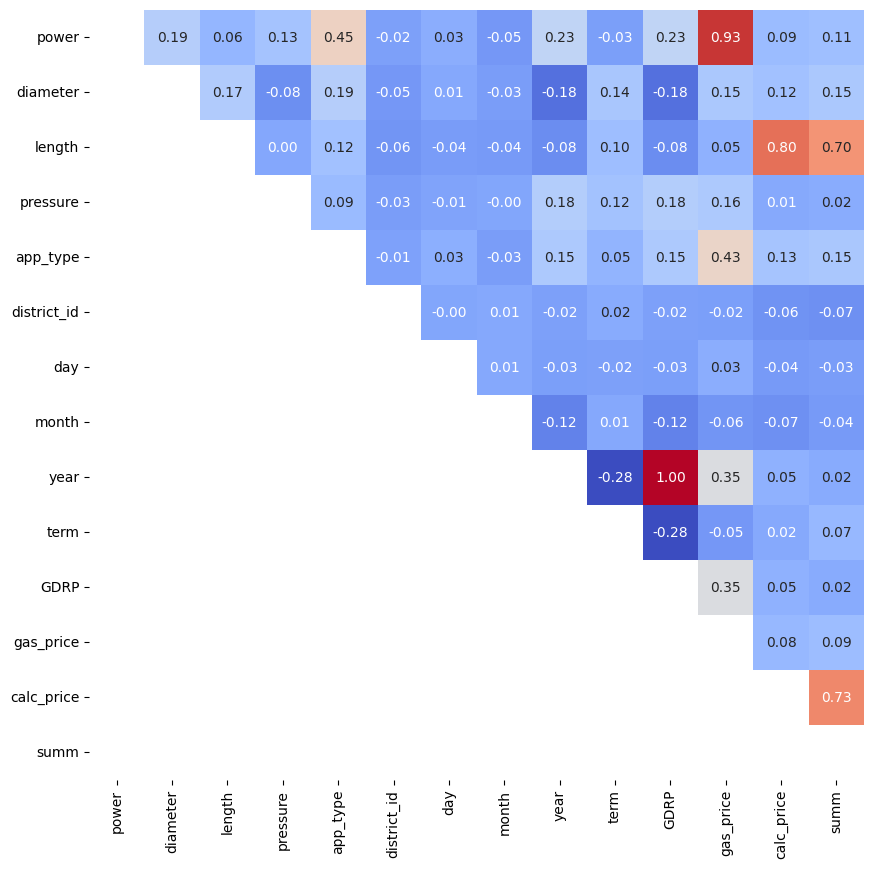

In [62]:
fig = plt.figure(figsize=(10,10))
matrix = np.tril(df.corr())
sns.heatmap(df.corr('kendall'), annot = True, fmt = '.2f', cmap= 'coolwarm', cbar=False, mask=matrix)
plt.show()

## **Выбор признаков для модели**

In [63]:
#Выбор признаков для модели
array = df.values
X = array[:,0:13]
Y = array[:,13]

In [64]:
X_train_test, X_val, Y_train_test, Y_val = train_test_split(X, Y, test_size=0.25, random_state=7)

In [65]:
feature_names = [list(df.columns.values[0:13])]
forest = RandomForestClassifier(random_state=7)
forest.fit(X, Y)

RandomForestClassifier(random_state=7)

In [66]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

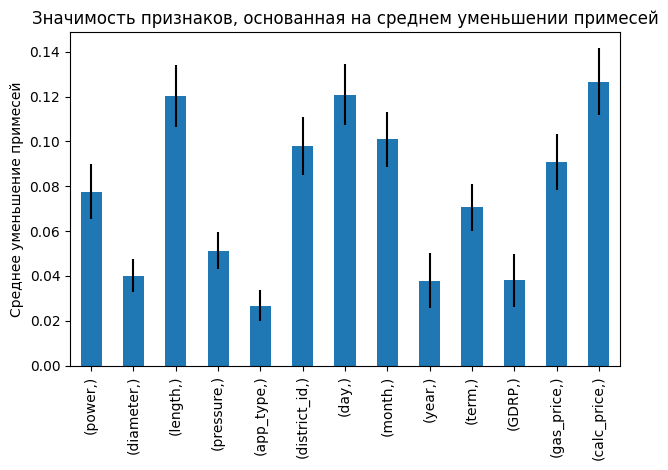

In [67]:
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Значимость признаков, основанная на среднем уменьшении примесей")
ax.set_ylabel("Среднее уменьшение примесей")
fig.tight_layout()

In [68]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

In [69]:
result = permutation_importance(forest, X_train_test, Y_train_test, n_repeats=10, random_state=7, n_jobs=2)
forest_importances = pd.Series(result.importances_mean, index=feature_names)

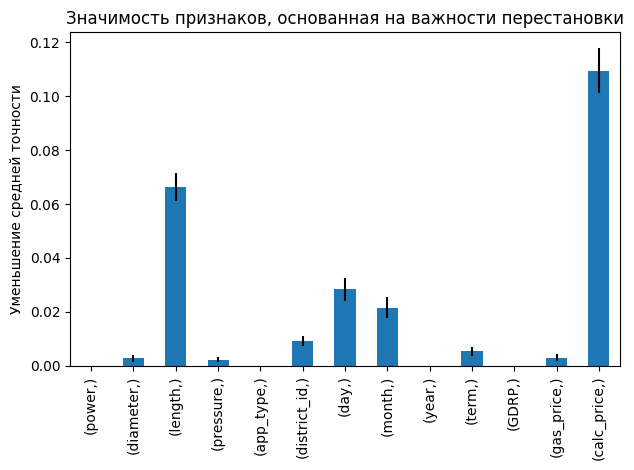

In [70]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Значимость признаков, основанная на важности перестановки")
ax.set_ylabel("Уменьшение средней точности")
fig.tight_layout()
plt.show()

## **Построение моделей**

In [121]:
#Построение моделей
model_df = df[['length', 'district_id', 'day', 'month', 'calc_price', 'summ']]
model_df

,length,district_id,day,month,calc_price,summ
0,100,4,1,10,257,324
1,67,10,1,11,199,176
2,42,10,2,4,155,177
3,12,6,2,7,102,180
4,36,6,3,4,144,240
...,...,...,...,...,...,...
1010,81,11,28,7,267,330
1011,50,17,28,7,192,233
1012,7,11,29,9,88,108
1013,6,11,29,9,86,105


In [122]:
array = model_df.values
X = array[:,0:5]
Y = array[:,5]

In [123]:
#r2
n_splits = 10
random_state = 7
n_estimators = 100
max_features = 4
max_depth = 3
seed = 7
learning_rate = 0.04
scoring = 'r2'
models = []
results = []
names = []
models.append(('LinRegr', LinearRegression()))
models.append(('SVM', SVR()))
models.append(('DTreeRrg', DecisionTreeRegressor(max_depth = max_depth)))
models.append(('ExTreeReg', ExtraTreesRegressor(n_estimators = n_estimators, max_features = max_features)))
models.append(('RaFoReg', RandomForestRegressor(n_estimators = n_estimators, max_features = max_features)))
models.append(('xgb', xgb.XGBRegressor(n_estimators = n_estimators, max_depth = max_depth, learning_rate = learning_rate, subsample= 0.5)))

for name, model in models:
    kfold = KFold(n_splits = n_splits, random_state = random_state, shuffle = True)
    cv_results = cross_val_score(model, X, Y, cv = kfold, scoring = scoring)
    results.append(cv_results)
    names.append(name)
    print(name, cv_results.mean().round(2), cv_results.std().round(2))

LinRegr 0.76 0.04
SVM 0.65 0.04
DTreeRrg 0.76 0.05
ExTreeReg 0.74 0.09
RaFoReg 0.74 0.08
xgb 0.77 0.06


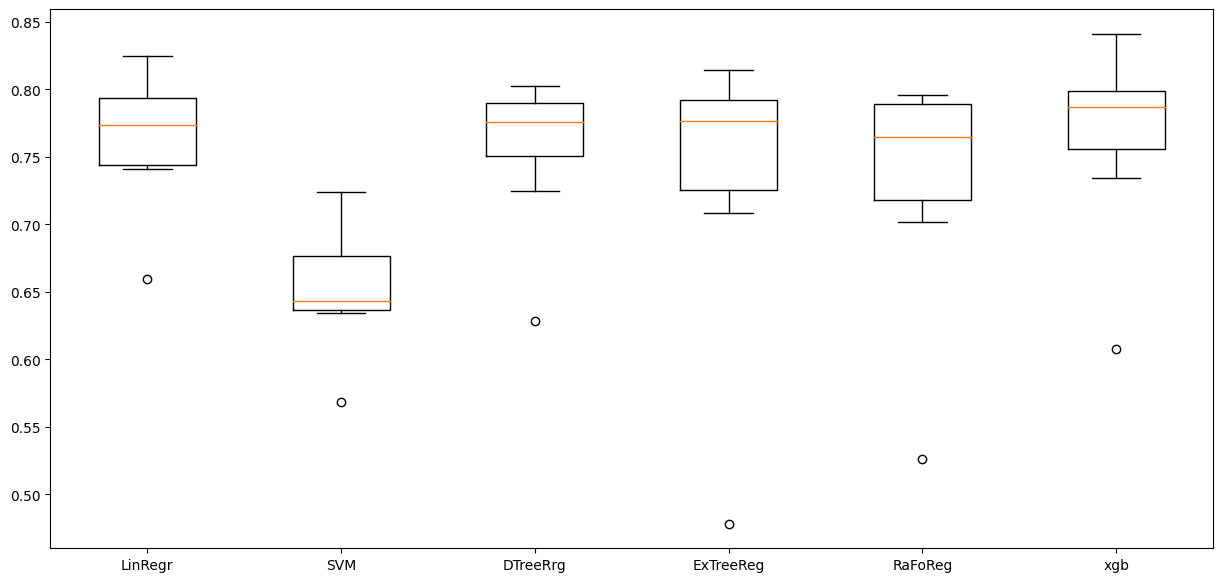

In [124]:
#Графическое представление r2
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot()
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [125]:
#Абсолютная ошибка
n_splits = 10
random_state = 7
n_estimators = 100
max_features = 4
max_depth = 3
seed = 7
learning_rate = 0.04
scoring = 'neg_mean_absolute_error'
models = []
results = []
names = []
models.append(('LinRegr', LinearRegression()))
models.append(('SVM', SVR()))
models.append(('DTreeRrg', DecisionTreeRegressor(max_depth = max_depth)))
models.append(('ExTreeReg', ExtraTreesRegressor(n_estimators = n_estimators, max_features = max_features)))
models.append(('RaFoReg', RandomForestRegressor(n_estimators = n_estimators, max_features = max_features)))
models.append(('xgb', xgb.XGBRegressor(n_estimators = n_estimators, max_depth = max_depth, learning_rate = learning_rate, subsample= 0.5)))

for name, model in models:
    kfold = KFold(n_splits = n_splits, random_state = random_state, shuffle = True)
    cv_results = cross_val_score(model, X, Y, cv = kfold, scoring = scoring)
    results.append(cv_results)
    names.append(name)
    print(name, cv_results.mean().round(2), (-(cv_results.mean()/df['summ'].mean()) * 100).round(2))

LinRegr -32.82 18.14
SVM -37.35 20.65
DTreeRrg -33.5 18.52
ExTreeReg -35.01 19.36
RaFoReg -34.6 19.13
xgb -32.35 17.88


In [126]:
df['summ'].mean()

180.89655172413794

In [139]:
#Разбивка выборки на тренировочную и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=7)

In [141]:
#Средняя абсолютная ошибка в процентах
random_state = 7
n_estimators = 100
max_features = 4
max_depth = 3
seed = 7
learning_rate = 0.04

LinRegr = LinearRegression()
result_LinRegr = LinRegr.fit(X_train, y_train)
Y_LinRegr = LinRegr.predict(X_test)
MAPE_LinRegr = mean_absolute_percentage_error(y_test,Y_LinRegr)

svr = SVR()
result_svr = svr.fit(X_train, y_train)
Y_svr = svr.predict(X_test)
MAPE_svr = mean_absolute_percentage_error(y_test,Y_svr)

DecTreeReg = DecisionTreeRegressor(max_depth = max_depth)
result_DecTreeReg = DecTreeReg.fit(X_train, y_train)
Y_DecTreeReg = DecTreeReg.predict(X_test)
MAPE_DecTreeReg = mean_absolute_percentage_error(y_test,Y_DecTreeReg)

ExTreeReg = ExtraTreesRegressor(n_estimators = n_estimators, max_features = max_features)
result_ExTreeReg = ExTreeReg.fit(X_train, y_train)
Y_ExTreeReg = ExTreeReg.predict(X_test)
MAPE_ExTreeReg = mean_absolute_percentage_error(y_test,Y_ExTreeReg)

RaFoReg = RandomForestRegressor(n_estimators = n_estimators, max_features = max_features)
result_RaFoReg = RaFoReg.fit(X_train, y_train)
Y_RaFoReg = RaFoReg.predict(X_test)
MAPE_RaFoReg = mean_absolute_percentage_error(y_test,Y_RaFoReg)

XGB = xgb.XGBRegressor(n_estimators = n_estimators, max_depth = max_depth, learning_rate = learning_rate, subsample= 0.5)
result_XGB = XGB.fit(X_train, y_train)
Y_XGB = XGB.predict(X_test)
MAPE_XGB = mean_absolute_percentage_error(y_test,Y_XGB)

print((MAPE_LinRegr * 100).round(2), (MAPE_svr * 100).round(2), (MAPE_DecTreeReg * 100).round(2), (MAPE_ExTreeReg * 100).round(2), (MAPE_RaFoReg * 100).round(2), (MAPE_XGB * 100).round(2))

18.24 18.72 19.81 19.98 20.28 18.21


In [144]:
#Симметричная средняя абсолютная процентная ошибка
random_state = 7
n_estimators = 100
max_features = 4
max_depth = 3
seed = 7
learning_rate = 0.04

def smape(real, predicted):
    return 1 / len(real) * np.sum(2 * np.abs(predicted - real) / (np.abs(real) + np.abs(predicted)) * 100)

LinRegr = LinearRegression()
result_LinRegr = LinRegr.fit(X_train, y_train)
Y_LinRegr = LinRegr.predict(X_test)
smape_LinRegr = smape(y_test,Y_LinRegr)

svr = SVR()
result_svr = svr.fit(X_train, y_train)
Y_svr = svr.predict(X_test)
smape_svr = smape(y_test,Y_svr)

DecTreeReg = DecisionTreeRegressor(max_depth = max_depth)
result_DecTreeReg = DecTreeReg.fit(X_train, y_train)
Y_DecTreeReg = DecTreeReg.predict(X_test)
smape_DecTreeReg = smape(y_test,Y_DecTreeReg)

ExTreeReg = ExtraTreesRegressor(n_estimators = n_estimators, max_features = max_features)
result_ExTreeReg = ExTreeReg.fit(X_train, y_train)
Y_ExTreeReg = ExTreeReg.predict(X_test)
smape_ExTreeReg = smape(y_test,Y_ExTreeReg)

RaFoReg = RandomForestRegressor(n_estimators = n_estimators, max_features = max_features)
result_RaFoReg = RaFoReg.fit(X_train, y_train)
Y_RaFoReg = RaFoReg.predict(X_test)
smape_RaFoReg = smape(y_test,Y_RaFoReg)

XGB = xgb.XGBRegressor(n_estimators = n_estimators, max_depth = max_depth, learning_rate = learning_rate, subsample= 0.5)
result_XGB = XGB.fit(X_train, y_train)
Y_XGB = XGB.predict(X_test)
smape_XGB = smape(y_test,Y_XGB)

print(smape_LinRegr.round(2), smape_svr.round(2), smape_DecTreeReg.round(2), smape_ExTreeReg.round(2), smape_RaFoReg.round(2), smape_XGB.round(2))

17.99 19.76 19.18 18.94 18.94 17.8


In [145]:
#Расчет значений для визуализации
LinRegr = LinearRegression()
result_LinRegr = LinRegr.fit(X_train, y_train)
Y_LinRegr = LinRegr.predict(X_test)

svr = SVR()
result_svr = svr.fit(X_train, y_train)
Y_svr = svr.predict(X_test)

DecTreeReg = DecisionTreeRegressor()
result_DecTreeReg = DecTreeReg.fit(X_train, y_train)
Y_DecTreeReg = DecTreeReg.predict(X_test)

ExTreeReg = ExtraTreesRegressor(n_estimators = n_estimators, max_features = max_features)
result_ExTreeReg = ExTreeReg.fit(X_train, y_train)
Y_ExTreeReg = ExTreeReg.predict(X_test)

RaFoReg = RandomForestRegressor(n_estimators = n_estimators, max_features = max_features)
result_RaFoReg = RaFoReg.fit(X_train, y_train)
Y_RaFoReg = RaFoReg.predict(X_test)

XGB = xgb.XGBRegressor(n_estimators = n_estimators, max_depth = max_depth, learning_rate = learning_rate, subsample= 0.5)
result_XGB = XGB.fit(X_train, y_train)
Y_XGB = XGB.predict(X_test)

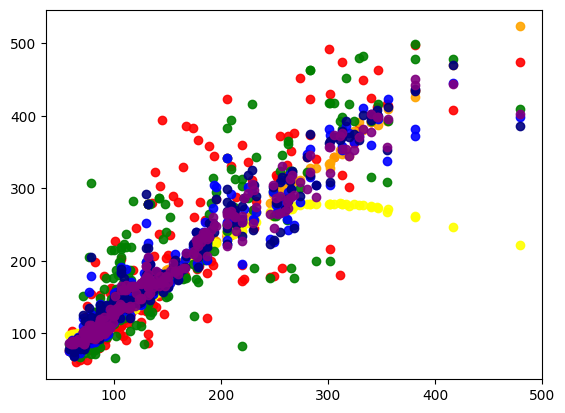

In [146]:
#Графическое представление результатов
fig, ax = plt.subplots()
ax.scatter(X_test[:,-1], y_test, color='red', alpha=0.9)
ax.scatter(X_test[:,-1], Y_LinRegr, color='orange', alpha=0.9)
ax.scatter(X_test[:,-1], Y_svr, color='yellow', alpha=0.9)
ax.scatter(X_test[:,-1], Y_DecTreeReg, color='green', alpha=0.9)
ax.scatter(X_test[:,-1], Y_ExTreeReg, color='blue', alpha=0.9)
ax.scatter(X_test[:,-1], Y_RaFoReg, color='navy', alpha=0.9)
ax.scatter(X_test[:,-1], Y_XGB, color='purple', alpha=0.9)
plt.show()

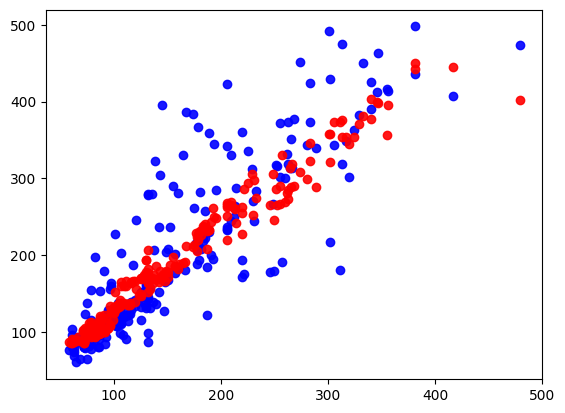

In [153]:
fig, ax = plt.subplots()
ax.scatter(X_test[:,-1], y_test, color='blue', alpha=0.9)
# ax.scatter(X_test[:,-1], Y_LinRegr, color='red', alpha=0.9)
# ax.scatter(X_test[:,-1], Y_svr, color='red', alpha=0.9)
# ax.scatter(X_test[:,-1], Y_DecTreeReg, color='red', alpha=0.9)
# ax.scatter(X_test[:,-1], Y_ExTreeReg, color='red', alpha=0.9)
# ax.scatter(X_test[:,-1], Y_RaFoReg, color='red', alpha=0.9)
ax.scatter(X_test[:,-1], Y_XGB, color='red', alpha=0.9)
plt.show()